Create support figures based on CESM2 ensemble members (CMIP6). The examined variables are sea surface temperature (North Atlantic) and AMOC.

# Preparation

## Modules

In [19]:
import sys
import os
import warnings
import pickle

import matplotlib.patches as mpatches
import numpy as np
import cftime
import xarray as xr
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec
import matplotlib
import cartopy
import cartopy.crs as ccrs
import pop_tools
import cmocean
import gsw
from mpl_toolkits.axes_grid1 import ImageGrid
sys.path.insert(0, "/home/dpfluger/scripts/cesm_tools/")
import cesm_data_tools
import pop_plot
import cesm_scenarios
import geo_tools
#import msf_tools

plt.style.use('seaborn')
warnings.filterwarnings('ignore')
matplotlib.rcParams['font.family'] = 'Nimbus Roman'
%reload_ext autoreload
%autoreload 2
# reset to standard notebook plotting after enabling animated plots
%matplotlib inline 

## Load scenarios

In [20]:
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01',
                                                        'years': np.arange(2015,2100)
                                                       }}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02','years': np.arange(2045,2100)} }

#cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)} }         
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.05',
                                                        'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06',
                                                        'years': np.arange(2086,2100)}
}

cases_sai80j = {'b.e21.BSSP585cmip6.f09_g17.feedback.09': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09',
                                                        'years': np.arange(2080,2100)},
}

cases = [cases_cnt, cases_sai20, cases_sai80, cases_sai80j]
#cases = [cases_cnt, cases_sai20, cases_sai80]
#cases_new = [cases_sai80j] # add SAI 2080 J data

scenario_names = ['Control', 'SAI 2020', 'SAI 2080', 'SAI 2080 J']
#scenario_names_new = ['SAI 2080 J']

scenarios = {name: cesm_scenarios.Scenario(name,case) for name, case in zip(scenario_names,cases)}

In [21]:
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01',
                                                        'years': np.arange(2015,2100)
                                                       }}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02','years': np.arange(2045,2100)} }

#cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01','years': np.arange(2020,2045)} }         
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.05',
                                                        'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.06',
                                                        'years': np.arange(2086,2100)}
}

cases_sai80j = {'b.e21.BSSP585cmip6.f09_g17.feedback.09': {'directory': '/gpfs/work4/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09',
                                                        'years': np.arange(2080,2100)},
}

cases = [cases_cnt, cases_sai20, cases_sai80, cases_sai80j]
#cases = [cases_cnt, cases_sai20, cases_sai80]
#cases_new = [cases_sai80j] # add SAI 2080 J data

scenario_names = ['Control', 'SAI 2020', 'SAI 2080', 'SAI 2080 J']
#scenario_names_new = ['SAI 2080 J']

scenarios = {name: cesm_scenarios.Scenario(name,case) for name, case in zip(scenario_names,cases)}

In [22]:
get_ocn_vars = ['TEMP', 'MOC', 'HMXL']

for var in get_ocn_vars:
    for name in scenarios:
        scenarios[name].get_ocn_var(var)

In [23]:
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea = pop_ds.TAREA * 10**(-4)
dz = pop_ds.dz * 10**(-2)

## Masks

In [24]:
grid_name = 'POP_gx1v7'
pop_regions = pop_tools.get_grid(grid_name)

# Global mask
pop_ds = xr.open_dataset('/home/dpfluger/links/leo_archive/b.e21.BSSP585cmip6.f09_g17.control.01/ocn/hist/b.e21.BSSP585cmip6.f09_g17.control.01.pop.h.2021-01.nc')
tarea_global = pop_ds.TAREA * 10**(-4)
tarea_global = tarea_global.where((pop_regions.REGION_MASK != 0)).fillna(0)
dz = pop_ds.dz * 10**(-2)

# Atlantic/Arctic sea regions
# 'Atlantic Ocean', 'Lab. Sea & Baffin Bay', 
# 'GIN Seas', 'Arctic Ocean', 'Hudson Bay'
#region_ids = [7,9,10,11,12]
region_ids = [7, 9]
pop_regions.region_name.isel(nreg=region_ids)
region_vals = pop_regions.region_val.sel(nreg=region_ids)

# select Atlantic and Polar seas
ones = xr.ones_like(pop_regions.REGION_MASK)
mask = xr.zeros_like(pop_regions.REGION_MASK)
for r_id in region_vals:
    mask_partial = ones.where(pop_regions.REGION_MASK==r_id)
    mask_partial = mask_partial.fillna(0)
    mask = mask + mask_partial
# Focus on Northern Atlantic
mask = mask.where((pop_regions.TLAT>45) & (pop_regions.TLAT<60)).fillna(0)

tarea_mask_na = tarea_global * mask

In [25]:
mx_march = scenarios['Control'].var['HMXL'].sel(time=slice('2015','2030')).groupby('time.month')[3]
mx_march = mx_march.mean(dim='time')

cut_off_depth = 55000
dwf_regions = mx_march>cut_off_depth
tarea_dwf = tarea_global.where(dwf_regions>0).fillna(0)

dwf_west = dwf_regions.where(dwf_regions.TLONG<318).fillna(0)
dwf_east = dwf_regions.where(dwf_regions.TLONG>318).fillna(0)

tarea_dwf_west = tarea_global.where(dwf_west>0).fillna(0)
tarea_dwf_east = tarea_global.where(dwf_east>0).fillna(0)

In [26]:
sst, sst_east, sst_west = {}, {}, {}

for var_name, var_dict in zip(['sst','sst_east','sst_west'],[sst,sst_east,sst_west]):
    for name in scenarios:
        da = xr.open_dataset(f'./data/{var_name}_{name}.nc')
        da = da[list(da.data_vars.keys())[0]]
        var_dict[name] = da

## Load CMIP6

In [27]:
cmip6_sst_path = '/home/dpfluger/analysis/ocean_convection/cmip6_data/'
scenario_labels = [
    'ssp126','ssp245','ssp370','ssp585'
]
ens_labels = [
    'r4i1p1f1', 'r10i1p1f1', 'r11i1p1f1'
]

da_scenario_container = []
for scenario in scenario_labels:
    print(scenario)
    da_ens_container = []
    for ens in ens_labels:
        print(ens)
        da_temp = xr.concat( 
            [xr.open_dataset(f'{cmip6_sst_path}tos_Omon_CESM2_{scenario}_{ens}_gn_201501-206412.nc',chunks={'time': 12}).tos
            ,xr.open_dataset(f'{cmip6_sst_path}tos_Omon_CESM2_{scenario}_{ens}_gn_206501-210012.nc',chunks={'time': 12}).tos]
            ,dim='time')
        da_temp = da_temp.rename({'lon': 'TLONG', 'lat': 'TLAT'})
        da_ens_container.append(da_temp)
    da_ens = xr.concat(da_ens_container,dim='ens')
    da_scenario_container.append(da_ens)
sst_cmip6 = xr.concat(da_scenario_container,dim='scenario')

ssp126
r4i1p1f1
r10i1p1f1
r11i1p1f1
ssp245
r4i1p1f1
r10i1p1f1
r11i1p1f1
ssp370
r4i1p1f1
r10i1p1f1
r11i1p1f1
ssp585
r4i1p1f1
r10i1p1f1
r11i1p1f1


## Util

In [33]:
def dwf_mean(da,mask_roi=tarea_dwf):
    
    weighted_sum = (da * mask_roi).sum(dim=['nlat','nlon'])
    norm = mask_roi.sum()
    
    return weighted_sum/norm

# SST plot

In [34]:
fsize = 8
fsize_min = 6

fontf = {'family': 'Nimbus Roman',
        'fontsize': 8
        }

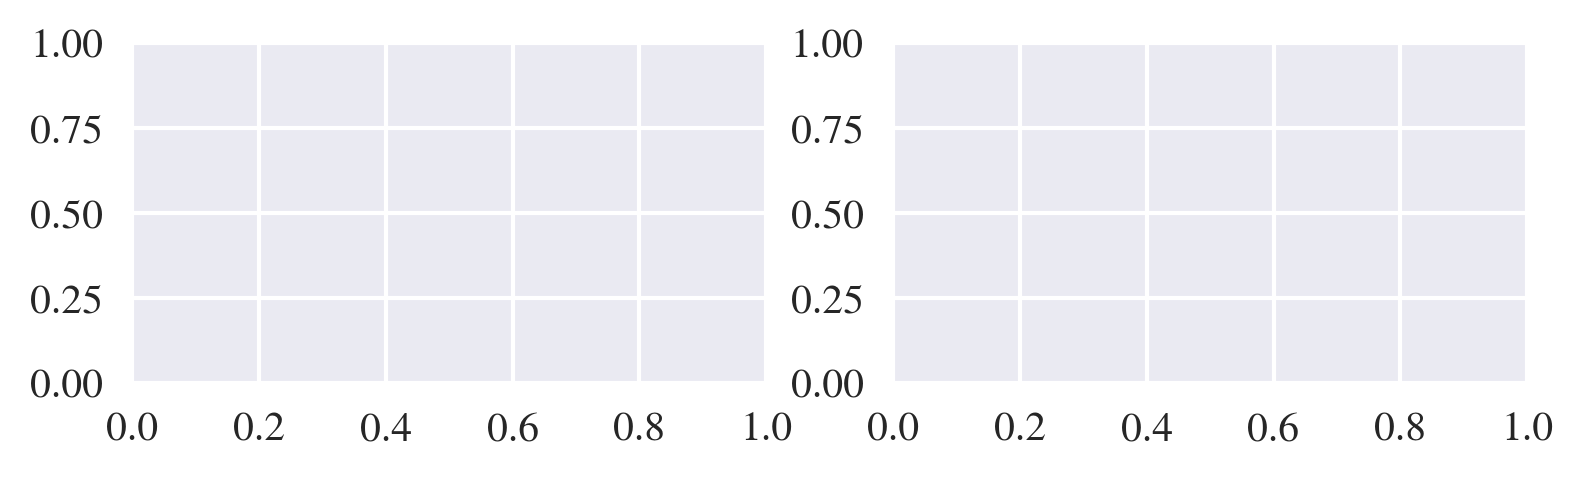

In [35]:
fig , axes = plt.subplots(1, 2, dpi=300,figsize=(6,1.5))

In [64]:
scenario_names = ['SSP-1.26','SSP-2.45','SSP-3.70','SSP-5.85']

In [65]:
axes[0].clear()
for name in ['Control', 'SAI 2020']:
    sst[name]\
    .groupby('time.month')[9]\
    .groupby('time.year').mean(dim='time')\
    .plot(ax=axes[0],alpha=0.5,linewidth=0.8)
    
ln_styles = ['solid', 'dashed', 'dotted', 'dashdot']
for scenario_n, ln_style, name in zip([0,1,2,3], ln_styles, scenario_names):
    print(scenario_n)
    dwf_mean(sst_cmip6.isel(scenario=scenario_n).mean(dim='ens'))\
        .groupby('time.month')[9]\
        .groupby('time.year').mean(dim='time')\
        .plot(ax=axes[0],color='black',linestyle=ln_style,linewidth=0.8,label=name)

0
1
2
3


In [87]:
axes[1].clear()
for name in ['Control', 'SAI 2020']:
    sst[name]\
    .groupby('time.year').mean(dim='time')\
    .plot(ax=axes[1],alpha=0.5,linewidth=0.8,label=name)

ln_styles = ['solid', 'dashed', 'dotted', 'dashdot']
for scenario_n, ln_style in zip([0,1,2,3], ln_styles):
    print(scenario_n)
    dwf_mean(sst_cmip6.isel(scenario=scenario_n).mean(dim='ens'))\
        .groupby('time.year').mean(dim='time')\
        .plot(ax=axes[1],color='black',linestyle=ln_style,linewidth=0.8)

0
1
2
3


In [88]:
axes[0].set_ylabel('SST [°C]',fontdict=fontf)
axes[1].set_ylabel(None)

axes[0].set_xlabel('Time',fontdict=fontf)
axes[1].set_xlabel('Time',fontdict=fontf)

axes[0].set_title('September mean',fontdict=fontf,fontsize=fsize)
axes[1].set_title('Annual mean',fontdict=fontf,fontsize=fsize)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=fsize_min, pad=4.0)
    ax.set_xlim([2015,2100])

axes[0].set_yticks([2,4,6,8,10,12,14])
axes[1].set_yticks([2,4,6,8,10,12,14])

axes[0].set_ylim([6,14])
axes[1].set_ylim([4,11])

# Put a legend below current axis
axes[0].legend(loc='upper center', bbox_to_anchor=(1.1, -0.25),
          frameon=True, ncol=4, fontsize=fsize_min)
axes[1].legend(fontsize=fsize_min,frameon=True)

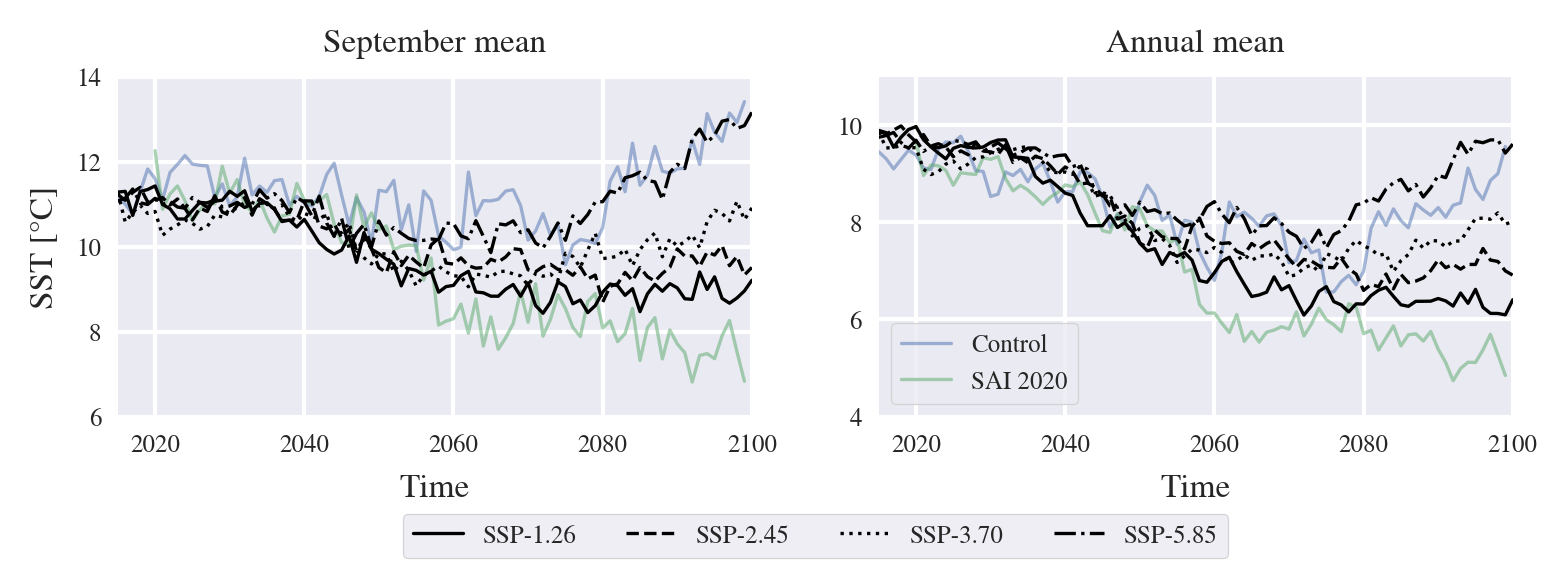

<Figure size 432x288 with 0 Axes>

In [89]:
plt.tight_layout()
fig

In [91]:
fig.savefig('./gfx/rev_natl_sst_cmip6.pdf',bbox_inches='tight')

'NimbusRoman-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
